In [1]:
import numpy as  np

In [2]:
import tensorflow as tf

/home/larry/tensorflow_1p5/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/larry/tensorflow_1p5/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/larry/tensorflow_1p5/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/larry/tensorflow_1p5/env/lib/python3.6/site-packages

In [3]:
print(tf.__version__)

1.5.0


In [4]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [5]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results


In [6]:
corpus = remove_stop_words(corpus)

In [7]:
corpus 

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [8]:
words = []
for text in corpus:
    #print(text)
    for word in text.split(' '):
        #print(word)
        words.append(word)

In [9]:
words

['king',
 'strong',
 'man',
 'queen',
 'wise',
 'woman',
 'boy',
 'young',
 'man',
 'girl',
 'young',
 'woman',
 'prince',
 'young',
 'king',
 'princess',
 'young',
 'queen',
 'man',
 'strong',
 'woman',
 'pretty',
 'prince',
 'boy',
 'king',
 'princess',
 'girl',
 'queen']

In [10]:
import os
import utils
from collections import Counter
utils.safe_mkdir('visualization')
file = open(os.path.join('visualization', 'vocab00.tsv'), 'w')

count = [('UNK', -1)]
count.extend(Counter(words).most_common(140))

In [11]:
print(len(count))
print(count[0])
print(count[1])
print(count[2])
print(count[3])
print(count[4])
print(count[5])
print(count[6])
print(count[7])
print(count[8])
print(count[9])
print(count[10])
print(count[11])
print(count[12])



13
('UNK', -1)
('young', 4)
('king', 3)
('man', 3)
('queen', 3)
('woman', 3)
('strong', 2)
('boy', 2)
('girl', 2)
('prince', 2)
('princess', 2)
('wise', 1)
('pretty', 1)


In [12]:
index=0
dictionary = dict()
for word, _ in count:
        dictionary[word] = index
        print(word)
        print(index)
        index += 1

UNK
0
young
1
king
2
man
3
queen
4
woman
5
strong
6
boy
7
girl
8
prince
9
princess
10
wise
11
pretty
12


In [13]:
def convert_words_to_index(words, dictionary):
    """ Replace each word in the dataset with its index in the dictionary """
    return [dictionary[word] if word in dictionary else 0 for word in words]

In [14]:
index_words = convert_words_to_index(words, dictionary)

In [15]:
index_words

[2,
 6,
 3,
 4,
 11,
 5,
 7,
 1,
 3,
 8,
 1,
 5,
 9,
 1,
 2,
 10,
 1,
 4,
 3,
 6,
 5,
 12,
 9,
 7,
 2,
 10,
 8,
 4]

In [16]:
import random
SKIP_WINDOW=1
def generate_sample():
    """ Form training pairs according to the skip-gram model. """
    for index, center in enumerate(index_words):
        context = random.randint(1, SKIP_WINDOW)
        # get a random target before the center word
        for target in index_words[max(0, index - context): index]:
            yield center, target
        # get a random target after the center wrod
        for target in index_words[index + 1: index + context + 1]:
            yield center, target

In [17]:
def batch_gen(batch_size):
    single_gen = generate_sample()
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros(batch_size)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(single_gen)
        yield center_batch, target_batch

In [18]:
def gen():
    yield from batch_gen(BATCH_SIZE)

In [19]:
BATCH_SIZE=5
dataset = tf.data.Dataset.from_generator(gen, 
                                (tf.int32, tf.int32), 
                                (tf.TensorShape([BATCH_SIZE]), tf.TensorShape([BATCH_SIZE])))

In [20]:
iterator = dataset.make_initializable_iterator()
center_words, target_words = iterator.get_next()

In [21]:
VOCAB_SIZE=12
EMBED_SIZE=2
embed_matrix = tf.get_variable('embed_matrix', 
                                        shape=[VOCAB_SIZE, EMBED_SIZE],
                                        initializer=tf.random_uniform_initializer())

## embed : batch_size x embed_size 

In [22]:
embed = tf.nn.embedding_lookup(embed_matrix, center_words-1, name='embedding')

In [23]:
softmax_weight = tf.get_variable('smx_weight', shape=[EMBED_SIZE,VOCAB_SIZE])

row=np.zeros(12).astype('float32')
print(row.shape)
bias=np.array([row])
print(bias.shape)
print(bias)
b = tf.get_variable(name='bias0', initializer=tf.constant(bias) )


##  logit :   batch_size x VOCAB_size 
logit = tf.matmul(embed, softmax_weight) +b 
# define loss function to be NCE loss function

#entropyy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target_words, name='entropy')

#losss = tf.reduce_mean(entropyy, name='loss') # computes the mean over all the examples in the batch


(12,)
(1, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
entropyy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target_words-1, name='entropy')

In [25]:
loss = tf.reduce_mean(entropyy, name='loss') # computes the mean over all the examples in the batch

In [26]:
LEARNING_RATE = 0.01
with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

In [29]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.global_variables_initializer())
    total_loss =0.0
    for index in range(100000):
        try:
            #print('index=',index)
            loss_batch, _=sess.run([loss, optimizer])
            total_loss += loss_batch
            if (index+1)%100 == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / 100))
                total_loss=0
           # print(tt[1])
            #print(sess.run(softmax_weight))
        except tf.errors.OutOfRangeError:
            #print('index=',index)
            #print('out of oil')
            sess.run(iterator.initializer)
    vector=sess.run(embed_matrix)

/home/larry/tensorflow_1p5/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'batch_gen' raised StopIteration
  


Average loss at step 99:   2.2
Average loss at step 199:   2.2
Average loss at step 299:   2.2
Average loss at step 399:   2.2
Average loss at step 499:   2.2
Average loss at step 599:   2.2
Average loss at step 699:   2.1
Average loss at step 799:   2.1
Average loss at step 899:   2.1
Average loss at step 999:   2.1
Average loss at step 1199:   4.2
Average loss at step 1299:   2.1
Average loss at step 1399:   2.1
Average loss at step 1499:   2.1
Average loss at step 1599:   2.1
Average loss at step 1699:   2.1
Average loss at step 1799:   2.0
Average loss at step 1899:   2.0
Average loss at step 1999:   2.0
Average loss at step 2099:   2.0
Average loss at step 2299:   4.0
Average loss at step 2399:   2.0
Average loss at step 2499:   2.0
Average loss at step 2599:   2.0
Average loss at step 2699:   2.0
Average loss at step 2799:   2.0
Average loss at step 2899:   1.9
Average loss at step 2999:   1.9
Average loss at step 3099:   1.9
Average loss at step 3199:   1.9
Average loss at step 

Average loss at step 26899:   1.6
Average loss at step 26999:   1.6
Average loss at step 27099:   1.6
Average loss at step 27199:   1.6
Average loss at step 27299:   1.6
Average loss at step 27399:   1.6
Average loss at step 27599:   3.2
Average loss at step 27699:   1.6
Average loss at step 27799:   1.6
Average loss at step 27899:   1.6
Average loss at step 27999:   1.6
Average loss at step 28099:   1.6
Average loss at step 28199:   1.6
Average loss at step 28299:   1.6
Average loss at step 28399:   1.6
Average loss at step 28499:   1.6
Average loss at step 28699:   3.2
Average loss at step 28799:   1.6
Average loss at step 28899:   1.6
Average loss at step 28999:   1.6
Average loss at step 29099:   1.6
Average loss at step 29199:   1.6
Average loss at step 29299:   1.6
Average loss at step 29399:   1.6
Average loss at step 29499:   1.6
Average loss at step 29599:   1.6
Average loss at step 29799:   3.2
Average loss at step 29899:   1.6
Average loss at step 29999:   1.6
Average loss a

Average loss at step 53599:   1.6
Average loss at step 53699:   1.6
Average loss at step 53799:   1.6
Average loss at step 53999:   3.2
Average loss at step 54099:   1.6
Average loss at step 54199:   1.6
Average loss at step 54299:   1.6
Average loss at step 54399:   1.6
Average loss at step 54499:   1.6
Average loss at step 54599:   1.6
Average loss at step 54699:   1.6
Average loss at step 54799:   1.6
Average loss at step 54899:   1.6
Average loss at step 55099:   3.2
Average loss at step 55199:   1.6
Average loss at step 55299:   1.6
Average loss at step 55399:   1.6
Average loss at step 55499:   1.6
Average loss at step 55599:   1.6
Average loss at step 55699:   1.6
Average loss at step 55799:   1.6
Average loss at step 55899:   1.6
Average loss at step 55999:   1.6
Average loss at step 56199:   3.2
Average loss at step 56299:   1.6
Average loss at step 56399:   1.6
Average loss at step 56499:   1.6
Average loss at step 56599:   1.6
Average loss at step 56699:   1.6
Average loss a

Average loss at step 80399:   3.2
Average loss at step 80499:   1.6
Average loss at step 80599:   1.6
Average loss at step 80699:   1.6
Average loss at step 80799:   1.6
Average loss at step 80899:   1.6
Average loss at step 80999:   1.6
Average loss at step 81099:   1.6
Average loss at step 81199:   1.6
Average loss at step 81299:   1.6
Average loss at step 81499:   3.2
Average loss at step 81599:   1.6
Average loss at step 81699:   1.6
Average loss at step 81799:   1.6
Average loss at step 81899:   1.6
Average loss at step 81999:   1.6
Average loss at step 82099:   1.6
Average loss at step 82199:   1.6
Average loss at step 82299:   1.6
Average loss at step 82399:   1.6
Average loss at step 82599:   3.2
Average loss at step 82699:   1.6
Average loss at step 82799:   1.6
Average loss at step 82899:   1.6
Average loss at step 82999:   1.6
Average loss at step 83099:   1.6
Average loss at step 83199:   1.6
Average loss at step 83299:   1.6
Average loss at step 83399:   1.6
Average loss a

In [30]:
vector

array([[-0.21265112,  1.0527214 ],
       [-0.4643219 , -0.63834286],
       [-1.1560264 , -0.04065271],
       [ 0.5215059 ,  1.4900824 ],
       [ 1.0009837 , -3.2584188 ],
       [ 2.5295954 ,  1.933384  ],
       [ 2.8186824 ,  0.5072213 ],
       [ 0.81744975,  1.5400214 ],
       [ 1.5952566 , -2.9867413 ],
       [ 5.2503257 ,  0.72203636],
       [-0.45563054,  1.0023572 ],
       [ 1.2676234 ,  0.28571072]], dtype=float32)

In [31]:
import matplotlib.pyplot as plt

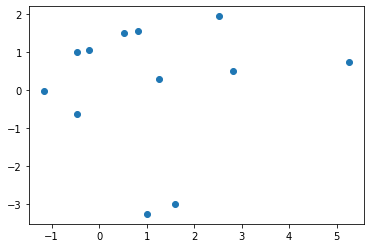

In [32]:
plt.scatter(vector[:,0], vector[:,1])